In [3]:
!pip install simpleitk

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Change the directory location here to run it on your Google Drive

In [5]:
import os
os.chdir('/content')
os.chdir('drive/MyDrive/Applications/Program Samples/promise12_UNet') # Change this line here to match your directory structure

In [6]:
# CISC 881
# Assignment 3
# By Fraser Raney
# ID 10027693

import numpy as np
import pandas as pd
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import stats
from collections import OrderedDict
from tqdm import tqdm
from sklearn.preprocessing import scale as Normalize
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
cuda = torch.device('cuda')

# PyTorchSummary
from torchsummary import summary

In [7]:
# readMhd method
# SimpleITK ReadImage wrapper from utils.py from the LNDb Challenge
# Reference: https://lndb.grand-challenge.org/
def readMhd(filename):
    # read mhd/raw image
    itkimage = sitk.ReadImage(filename)
    scan = sitk.GetArrayFromImage(itkimage) #3D image
    spacing = itkimage.GetSpacing() #voxelsize
    origin = itkimage.GetOrigin() #world coordinates of origin
    transfmat = itkimage.GetDirection() #3D rotation matrix
    return scan,spacing,origin,transfmat

In [8]:
# resample method
# returns resampled itk image with reference spacing (0.625, 0.625, 3.6)
# Reference: https://github.com/SimpleITK/SimpleITK/issues/561
def resample(filename, interpolator):
    itkImage = sitk.ReadImage(filename)
    refSpacing = np.array([0.625,0.625,3.6])
    resampler = sitk.ResampleImageFilter()

    # Set interpolator
    resampler.SetInterpolator(interpolator)
    #resampler.SetTransform(sitk.Transform(3,sitk.sitkIdentity))

    resampler.SetTransform(sitk.Transform())
    # Set out direction
    resampler.SetOutputDirection(itkImage.GetDirection())
    # Set out origin
    resampler.SetOutputOrigin(itkImage.GetOrigin())
    # Set out spacing
    resampler.SetOutputSpacing(refSpacing)
    # Calculate new size
    newSize = np.array(itkImage.GetSize()*(itkImage.GetSpacing()/refSpacing), dtype=np.uint).tolist()
    # Set out size
    resampler.SetSize(newSize)

    return resampler.Execute(itkImage)

In [9]:
# centerCrop method
# returns the center 224x224 crop of an SimpleITK image with all depth
def centerCrop(itkImage):
    # First pad the image to make sure its width x height is at least 224 x 224.
    padding = np.tile(0, 3)
    padding[0] = np.max([0, 224-itkImage.GetWidth()])
    padding[1] = np.max([0, 224-itkImage.GetHeight()])

    padder = sitk.MirrorPadImageFilter()
    padder.SetPadLowerBound(padding.tolist())
    padder.SetPadUpperBound(np.tile(0,3).tolist())
    paddedImage = padder.Execute(itkImage)

    # Slice out the center 224 x 224 region and include all depth
    wCenter = paddedImage.GetHeight() // 2
    hCenter = paddedImage.GetHeight() // 2

    return paddedImage[wCenter - 112: wCenter + 112, hCenter - 112: hCenter + 112, :]

In [10]:
# saveSlices method
# saves the top 5 slices with the most label region
def saveSlices(itkImage, itkLabel, case):
    def findMaxAxialIndices(label):
        sumIntensities = sitk.GetArrayFromImage(label).sum(axis=1).sum(axis=1)
        dic = OrderedDict(zip(range(len(sumIntensities)), sumIntensities))
        oDic = sorted(dic.items(), key= lambda x: x[1])
        return list(dict(oDic[-5:]).keys())

    def saveSlice(index):
        np.save(os.path.join(imagesTr, case.split('.')[0] + ("_z%d"%index).zfill(3)),
                sitk.GetArrayFromImage(itkImage)[index, :, :])
        np.save(os.path.join(labelsTr, case.split('.')[0] + ("_z%d"%index).zfill(3)),
               sitk.GetArrayFromImage(itkLabel)[index, :, :])

    [saveSlice(z) for z in findMaxAxialIndices(itkLabel)]

In [11]:
# preprocess_and_save method
# runs preprocessing for all the labels and images for resampling,
# cropping and slicing to save npy arrays
def preprocess_and_save(imgList, lblList):
    print("Preprocessing ...")
    imgList.sort()
    lblList.sort()
    with tqdm(total=50) as pbar:
        for lbl,img in zip(lblList, imgList):
            # a) Resample to a reference spacing of (0.625, 0.625, 3.6)
            pbar.set_description(("Resampling " + img.split('.')[0] + " ...").ljust(30, ' '))
            pbar.update(1)
            pbar.refresh
            resLbl = resample(os.path.join(RAW_DIR, lbl), sitk.sitkNearestNeighbor)
            resImg = resample(os.path.join(RAW_DIR, img), sitk.sitkLinear)

            # b) Crop to a central volume, 224 x 224, ignoring depth
            pbar.set_description(("Cropping " + img.split('.')[0] + " ...").ljust(30, ' '))
            pbar.refresh
            croppedImg = centerCrop(resImg)
            croppedLbl = centerCrop(resLbl)

            # c) save the five axial slices with the most label region
            pbar.set_description(("Saving " + img.split('.')[0] + " ...").ljust(30, ' '))
            pbar.refresh
            saveSlices(croppedImg, croppedLbl, img)

In [12]:
# flip_and_save method
# doubles the number of slices by flipping the image and label arrays along the y-axis
def flip_and_save(npyList):
    print("Flipping y-axis ...")
    def flipSave(npyName):
        imgA = np.load(os.path.join(imagesTr, npyName))
        lblA = np.load(os.path.join(labelsTr, npyName))
        pbar.set_description(("Saving " + npyName.split('.')[0] + " ...").ljust(30, ' '))
        pbar.update(1)
        pbar.refresh
        np.save(os.path.join(imagesTr, npyName.split('.')[0] + '_my'), np.fliplr(imgA))
        np.save(os.path.join(labelsTr, npyName.split('.')[0] + '_my'), np.fliplr(lblA))

    with tqdm(total=250) as pbar:
        [flipSave(npyFilename) for npyFilename in npyList]

In [13]:
# normalize_and_save method
# normalize the image arrays to zero-mean and unit-variance and save them again
def normalize_and_save(npyList):
    print("Normalizing axial slices ...")
    def normalizeSave(npyFilename):
        imgA = np.load(os.path.join(imagesTr, npyFilename))
        pbar.set_description(("Saving " + npyFilename.split('.')[0] + " ...").ljust(30, ' '))
        pbar.update(1)
        pbar.refresh
        np.save(os.path.join(imagesTr, npyFilename), Normalize(imgA))

    with tqdm(total=500) as pbar:
        [normalizeSave(npyName) for npyName in npyList]

In [14]:
# maybeMakeDir method
# wrapper for os.mkdir
def maybeMakeDir(dirName):
    if os.path.exists(dirName) and os.path.isdir(dirName):
        return
    else:
        os.mkdir(dirName)

In [15]:
# trainValTest method
# split into train, validation and test sets keeping case numbers together
def trainValTest(caseNos):
    train, valTest = train_test_split(caseNos, train_size=0.6, random_state=12345)
    validation, test = train_test_split(valTest, train_size=0.5, random_state=12345)

    # Make sure the Case number from part A is in the test set
    def switch(case, fromSet, toSet):
        fromSet.remove(case)
        toSet.append(case)
        switch = toSet[0]
        toSet = toSet[1:]
        fromSet.append(switch)

    if 'Case43' not in test:
        if 'Case43' in validation:
            switch('Case43', validation, test)
        else:
            switch('Case43', train, test)

    def fetchNpyNames(caseNos):
        return np.array(list(filter(lambda filename: filename.split('.')[-1] \
                                    == 'npy' and filename.split('_')[0] in caseNos,
                                    os.listdir(imagesTr))))
    return [fetchNpyNames(caseList) for caseList in [train, validation, test, ['Case43']]]

In [16]:
# Location of the raw data
RAW_DIR = './/data//train//'

# Preprocessing output folders
imagesTr = 'imagesTr'
labelsTr = 'labelsTr'

maybeMakeDir(imagesTr)
maybeMakeDir(labelsTr)

# Get the filenames for the images and the labels into arrays
imgFilenamesTr = np.array(list(filter(lambda filename: filename.split('.')[-1] == 'mhd' \
                                      and 'segmentation' not in filename.split('.')[0], os.listdir('data/train'))))

lblFilenamesTr = np.array(list(filter(lambda filename: filename.split('.')[-1] == 'mhd' \
                                      and 'segmentation' in filename.split('.')[0], os.listdir('data/train'))))

# a)-c): Preprocess and save
preprocess_and_save(imgFilenamesTr, lblFilenamesTr)

# Get the filenames for the saved npy arrays (n=250)
npyFileList = np.array(list(filter(lambda filename: filename.split('.')[-1] == 'npy', os.listdir('imagesTr'))))

# d) Double the number of slices by flipping along the y-axis
flip_and_save(npyFileList)

# Get the filenames for the saved npy arrays (n=500)
npyFileList = np.array(list(filter(lambda filename: filename.split('.')[-1] == 'npy', os.listdir('imagesTr'))))

# e) Normalize the intensity values of the images
normalize_and_save(npyFileList)

# Get the case identifiers
caseIds = [fname.split('.')[0] for fname in imgFilenamesTr]

# f) Split into train, validation and test sets keeping cases together
train, validation, test, case43 = trainValTest(caseIds)

Preprocessing ...


Saving Case49 ...             : 100%|██████████| 50/50 [03:44<00:00,  4.49s/it]


Flipping y-axis ...


Saving Case34_z10_my_my ...   : : 750it [03:58,  3.14it/s]


Normalizing axial slices ...


Saving Case34_z10_my_my_my ...: : 1000it [00:23, 42.38it/s]


In [17]:
# Promise12Dataset class
# PyTorch Dataset
class Promise12Dataset(torch.utils.data.Dataset):
    def __init__(self, listOfFiles):
        self.filenames = listOfFiles
    def __getitem__(self, index):
        img = np.load(os.path.join(imagesTr, self.filenames[index]))[np.newaxis, ...]
        target = np.load(os.path.join(labelsTr, self.filenames[index]))[np.newaxis, ...]
        return img, target
    def __len__(self):
        return len(self.filenames)

In [18]:
# g) UNet class
# PyTorch model
# Reference: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Reference: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

#n Reference: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Reference: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return F.sigmoid(self.conv(x))

# Reference: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py
class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Initialize
net = UNet().float().to(torch.device('cuda'))

summary(net, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
        DoubleConv-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,856
      BatchNorm2d-10        [-1, 128, 112, 112]             256
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         147,584
      BatchNorm2d-13        [-1, 128, 112, 112]             256
             ReLU-14        [-1, 128, 1

In [19]:
# h) Dice Score (DSC) and Dice loss

# dice_loss method
# returns 1 - DSC
# Reference: https://github.com/pytorch/pytorch/issues/1249
def dice_loss(inputs, target):

    smooth = 1.
    iflat = inputs.float().view(-1)
    tflat = target.float().view(-1)
    intersection = (iflat * tflat).sum()

    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

# dice_metric
# returns the DSC
# Reference: https://github.com/pytorch/pytorch/issues/1249
def dice_metric(inputs, target):

    smooth = 1.
    iflat = inputs.float().view(-1)
    tflat = target.float().view(-1)
    intersection = (iflat * tflat).sum()

    return ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [20]:
# datasetEval method
# prints the mean DSC loss and DSC for a dataloader
def datasetEval(loader):
    with torch.no_grad():
        running_loss = 0.
        running_dice = 0.
        for i, data in enumerate(loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            outputs = net(inputs.float().to(torch.device('cuda')))
            running_loss += dice_loss(outputs, labels.to(torch.device('cuda')))
            running_dice += dice_metric(outputs, labels.to(torch.device('cuda')))

    loss = running_loss / len(loader)
    dice = running_dice / len(loader)
    print(('loss: %.3f dice: %.3f' % (loss, dice)))

In [24]:
# Make the dataloaders
trainset = Promise12Dataset(train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
validationset = Promise12Dataset(validation)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=1,
                                          shuffle=True, num_workers=2)
testset = Promise12Dataset(test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=True, num_workers=2)
# Gradient optimizers
optimizer = optim.Adam(net.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

print("Training ...")

# Metric variables
statsTr = []
val_dice = 0.
prev_val_dice = 0.
running_val_loss = 0.
running_val_dice = 0.
running_dice = 0.
running_loss = 0.

# Main training loop
for epoch in range(100):  # loop over the dataset multiple times

    # Train
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float().to(torch.device('cuda')))
        loss = dice_loss(outputs, labels.to(torch.device('cuda')))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_dice += dice_metric(outputs, labels.to(torch.device('cuda')))

    train_loss = running_loss / len(trainloader)
    train_dice = running_dice / len(trainloader)
    print(('[epoch %d] train_loss: %.3f ' % (epoch + 1, train_loss)).ljust(30, ' '), end='')
    running_loss = 0.
    running_dice = 0.

    # Validation
    with torch.no_grad():
        for i, data in enumerate(validationloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # forward + backward + optimize
            outputs = net(inputs.float().to(torch.device('cuda')))
            running_val_loss += dice_loss(outputs, labels.to(torch.device('cuda')))
            running_val_dice += dice_metric(outputs, labels.to(torch.device('cuda')))

    val_loss = running_val_loss / len(validationloader)
    val_dice = running_val_dice / len(validationloader)
    print(('val_loss: %.3f val_dice: %.3f' % (val_loss, val_dice)).rjust(30, ' '))
    running_val_loss = 0.
    running_val_dice = 0.

    # Learning rate reduction
    scheduler.step(val_loss)

    # Record metrics
    statsTr.append({'epoch': (epoch + 1), 'lossTr': train_loss,
                    'diceTr': train_dice, 'lossVa': val_loss, 'diceVa': val_dice})

    # i) Early stopping
    if np.abs(val_dice.item() - prev_val_dice) < 0.0005: # for better results use 0.0001
        print("Early stopping")
        break

    prev_val_dice = val_dice.item()

print('Finished Training')

Training ...
[epoch 1] train_loss: 0.066   val_loss: 0.127 val_dice: 0.873
[epoch 2] train_loss: 0.057   val_loss: 0.128 val_dice: 0.872
[epoch 3] train_loss: 0.064   val_loss: 0.104 val_dice: 0.896
[epoch 4] train_loss: 0.049   val_loss: 0.107 val_dice: 0.893
[epoch 5] train_loss: 0.044   val_loss: 0.122 val_dice: 0.878
[epoch 6] train_loss: 0.047   val_loss: 0.198 val_dice: 0.802
[epoch 7] train_loss: 0.047   val_loss: 0.138 val_dice: 0.862
[epoch 8] train_loss: 0.051   val_loss: 0.105 val_dice: 0.895
[epoch 9] train_loss: 0.038   val_loss: 0.103 val_dice: 0.897
[epoch 10] train_loss: 0.035  val_loss: 0.105 val_dice: 0.895
[epoch 11] train_loss: 0.034  val_loss: 0.107 val_dice: 0.893
[epoch 12] train_loss: 0.034  val_loss: 0.106 val_dice: 0.894
[epoch 13] train_loss: 0.035  val_loss: 0.121 val_dice: 0.879
[epoch 14] train_loss: 0.034  val_loss: 0.100 val_dice: 0.900
[epoch 15] train_loss: 0.031  val_loss: 0.096 val_dice: 0.904
[epoch 16] train_loss: 0.029  val_loss: 0.105 val_dice: 0

In [25]:
# Write the metric table to file
statsDf = pd.DataFrame(statsTr)
statsDf['diceTr'] = statsDf['diceTr'].apply(lambda x: x.to(torch.device('cuda')).item())
statsDf['lossVa'] = statsDf['lossVa'].apply(lambda x: x.to(torch.device('cuda')).item())
statsDf['diceVa'] = statsDf['diceVa'].apply(lambda x: x.to(torch.device('cuda')).item())
statsDf.to_csv('metricsTr.csv')

# j) Get mean metrics for train, validation and test sets
# Train
print("Train mean:")
datasetEval(trainloader)
# Val
print("Validation mean:")
datasetEval(validationloader)
# Test
print("Test mean:")
datasetEval(testloader)

Train mean:
loss: 0.025 dice: 0.975
Validation mean:
loss: 0.105 dice: 0.895
Test mean:
loss: 0.099 dice: 0.901


Case43_z9_my_my.npy


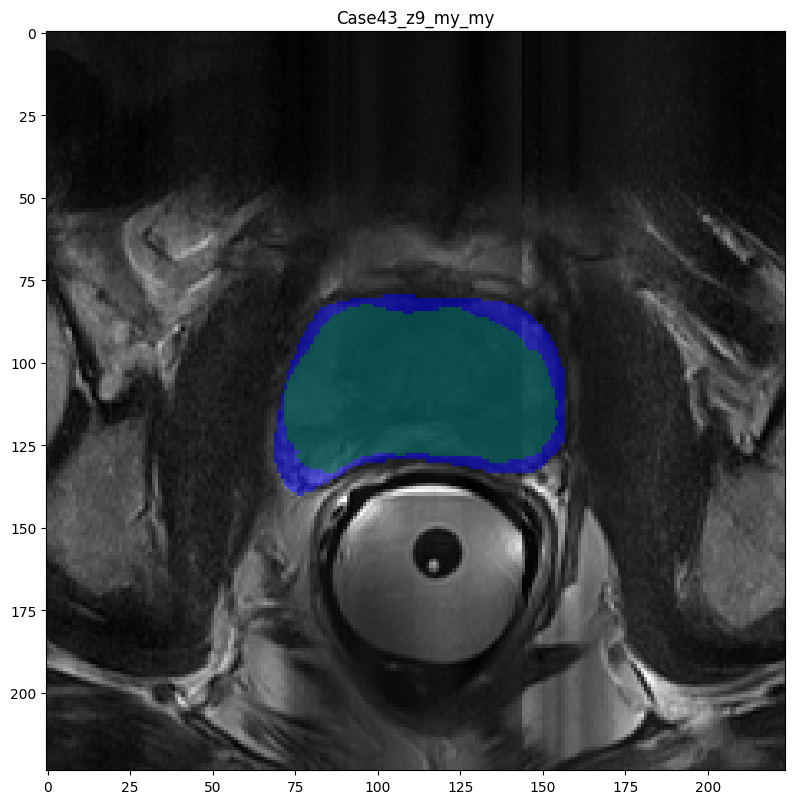

In [26]:
# k) Largest label area of the case from part A
sumIntensities = [np.load(os.path.join(labelsTr,fname)).sum() for fname in case43]
filen = case43[np.argmax(sumIntensities)]
print(filen)

with torch.no_grad():
    case43_out = net(torch.tensor([np.load(os.path.join(imagesTr, filen))[np.newaxis, ...]],
                                  device=torch.device('cuda')).float())

green = ListedColormap(['green'])
blue = ListedColormap(['blue'])
def getLabelMask(npyA):
    labelA = npyA.astype(int)
    return np.ma.masked_where(labelA == 0., labelA)

plt.figure(figsize=(9.6,9.6))
plt.subplot(111)
plt.imshow(np.load(os.path.join(imagesTr, filen)), cmap='gray')
plt.imshow(getLabelMask(np.load(os.path.join(labelsTr, filen))), cmap=blue, alpha=0.5)
plt.imshow(getLabelMask(case43_out.squeeze().cpu().numpy()), cmap=green, alpha=0.5)
plt.title(filen.split('.')[0])
plt.savefig("case43", format='png')